## Step 0. basic setup

In [2]:
# Test basic environment
import torch
import transformer_lens
from transformers import __version__ as transformers_version
import os

print("🔧 Environment Check:")
print(f"PyTorch: {torch.__version__}")
print(f"TransformerLens: {transformer_lens}")
print(f"Transformers: {transformers_version}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name()}")
print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f}GB")

# Check HF token
hf_token = os.getenv('HF_TOKEN')
print(f"HF Token loaded: {'✅' if hf_token else '❌'}")

🔧 Environment Check:
PyTorch: 2.8.0.dev20250319+cu128
TransformerLens: <module 'transformer_lens' from '/usr/local/lib/python3.11/dist-packages/transformer_lens/__init__.py'>
Transformers: 4.56.0
CUDA available: True
GPU: NVIDIA RTX A6000
GPU Memory: 51.0GB
HF Token loaded: ✅


In [3]:
from transformer_lens import HookedTransformer
from transformers import LlamaTokenizer
import torch
import gc

print("🚀 Loading Llama-2-13B-chat...")
print("This will download ~26GB - grab some coffee! ☕")

# Memory management
def clear_memory():
    gc.collect()
    torch.cuda.empty_cache()
    memory_gb = torch.cuda.memory_allocated() / 1e9
    print(f"GPU Memory: {memory_gb:.1f}GB")

# Load model with optimizations
model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-2-13b-chat-hf",
    torch_dtype=torch.bfloat16,  # Save memory
    device_map="auto",           # Auto GPU placement
    fold_ln=False,               # Keep for interpretability
    center_writing_weights=False, # Keep original weights
)

# Load tokenizer
tokenizer = LlamaTokenizer.from_pretrained("meta-llama/Llama-2-13b-chat-hf")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

clear_memory()
print("✅ Llama-2-13B loaded successfully!")
print(f"Model layers: {model.cfg.n_layers}")
print(f"Hidden size: {model.cfg.d_model}")

🚀 Loading Llama-2-13B-chat...
This will download ~26GB - grab some coffee! ☕


config.json:   0%|          | 0.00/587 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json:   0%|          | 0.00/33.4k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/6.18G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/9.90G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/9.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

Loaded pretrained model meta-llama/Llama-2-13b-chat-hf into HookedTransformer
GPU Memory: 26.8GB
✅ Llama-2-13B loaded successfully!
Model layers: 40
Hidden size: 5120


In [6]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import google.generativeai as genai
import time
import os

In [7]:
# refined_prompts.csv is generated by Claude
# for each topic, there are 2 prompts with the same token length,
# each prompt stands for a epistemic status: certain or uncertain
df = pd.read_csv('data/refined_prompts.csv')

In [9]:
df

,topic,epistemic_status,prompt
0,climate_change,certain,Climate change is definitely caused by human a...
1,climate_change,uncertain,Climate change is probably caused by human act...
2,python_learning,certain,Python is definitely the best programming lang...
3,python_learning,uncertain,Python is probably the best programming langua...
4,exercise_health,certain,Regular exercise definitely prevents heart dis...
...,...,...,...
75,mars_colonization,uncertain,Private companies will probably establish perm...
76,artificial_intelligence,certain,Artificial general intelligence will definitel...
77,artificial_intelligence,uncertain,Artificial general intelligence will probably ...
78,job_automation,certain,Artificial intelligence will definitely elimin...


#### Before experimet, double-check each pair of prompts has the same length of tokens

In [ ]:
# Group by topic to get pairs
topics = df['topic'].unique()
mismatches = []

for topic in topics:
    topic_data = df[df['topic'] == topic]
    certain_prompt = topic_data[topic_data['epistemic_status'] == 'certain']['prompt'].iloc[0]
    uncertain_prompt = topic_data[topic_data['epistemic_status'] == 'uncertain']['prompt'].iloc[0]
    
    certain_tokens = len(tokenizer.encode(certain_prompt))
    uncertain_tokens = len(tokenizer.encode(uncertain_prompt))
    
    if certain_tokens != uncertain_tokens:
        mismatches.append({
            'topic': topic,
            'certain_tokens': certain_tokens,
            'uncertain_tokens': uncertain_tokens,
            'difference': abs(certain_tokens - uncertain_tokens)
        })
        print(f"❌ {topic}: {certain_tokens} vs {uncertain_tokens}")
    else:
        print(f"✅ {topic}: {certain_tokens} tokens")

if mismatches:
    print(f"\n⚠️  Found {len(mismatches)} mismatched pairs!")
else:
    print(f"\n🎉 All {len(topics)} pairs are token-matched!")

## Step 1. Generate response from Llama-2-13B 

In [24]:
def generate_response_from_chat_model(prompt, temperature=0.7):
    """Generate text with Llama-2-13B"""
    
    # Tokenize input
    tokens = tokenizer.encode(prompt, return_tensors="pt").to(model.cfg.device)
    print(f"Input tokens shape: {tokens.shape}")
    
    # Generate with the model
    generated_tokens = model.generate(tokens, 
       max_new_tokens=50,
       temperature=0.7,
       do_sample=True)
    
    # Decode response
    response = tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
    return response

In [25]:
responses = []
    
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Generating responses"):
    try:
        response = generate_response_from_chat_model(row['prompt'])
        responses.append(response)
    except Exception as e:
        print(f"Error generating response for prompt {idx}: {e}")
        responses.append(f"ERROR: {str(e)}")

# Add responses to dataframe
df['model_response'] = responses

Generating responses:   0%|          | 0/80 [00:00<?, ?it/s]

Input tokens shape: torch.Size([1, 17])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:   1%|▏         | 1/80 [00:04<05:42,  4.34s/it]

Input tokens shape: torch.Size([1, 17])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:   2%|▎         | 2/80 [00:08<05:37,  4.33s/it]

Input tokens shape: torch.Size([1, 18])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:   4%|▍         | 3/80 [00:12<05:33,  4.33s/it]

Input tokens shape: torch.Size([1, 18])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:   5%|▌         | 4/80 [00:17<05:29,  4.34s/it]

Input tokens shape: torch.Size([1, 17])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:   6%|▋         | 5/80 [00:21<05:25,  4.34s/it]

Input tokens shape: torch.Size([1, 17])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:   8%|▊         | 6/80 [00:26<05:21,  4.35s/it]

Input tokens shape: torch.Size([1, 20])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:   9%|▉         | 7/80 [00:30<05:17,  4.35s/it]

Input tokens shape: torch.Size([1, 20])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  10%|█         | 8/80 [00:34<05:13,  4.35s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  11%|█▏        | 9/80 [00:39<05:09,  4.36s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  12%|█▎        | 10/80 [00:43<05:05,  4.36s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  14%|█▍        | 11/80 [00:47<05:01,  4.37s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  15%|█▌        | 12/80 [00:52<04:57,  4.37s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  16%|█▋        | 13/80 [00:56<04:53,  4.37s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  18%|█▊        | 14/80 [01:01<04:48,  4.38s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  19%|█▉        | 15/80 [01:05<04:44,  4.38s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  20%|██        | 16/80 [01:09<04:40,  4.38s/it]

Input tokens shape: torch.Size([1, 20])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  21%|██▏       | 17/80 [01:14<04:35,  4.38s/it]

Input tokens shape: torch.Size([1, 20])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  22%|██▎       | 18/80 [01:18<04:31,  4.38s/it]

Input tokens shape: torch.Size([1, 26])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  24%|██▍       | 19/80 [01:22<04:27,  4.39s/it]

Input tokens shape: torch.Size([1, 26])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  25%|██▌       | 20/80 [01:27<04:23,  4.39s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  26%|██▋       | 21/80 [01:31<04:19,  4.39s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  28%|██▊       | 22/80 [01:36<04:14,  4.40s/it]

Input tokens shape: torch.Size([1, 20])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  29%|██▉       | 23/80 [01:40<04:10,  4.40s/it]

Input tokens shape: torch.Size([1, 20])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  30%|███       | 24/80 [01:44<04:06,  4.40s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  31%|███▏      | 25/80 [01:49<04:01,  4.40s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  32%|███▎      | 26/80 [01:53<03:57,  4.40s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  34%|███▍      | 27/80 [01:58<03:53,  4.40s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  35%|███▌      | 28/80 [02:02<03:48,  4.40s/it]

Input tokens shape: torch.Size([1, 18])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  36%|███▋      | 29/80 [02:06<03:44,  4.40s/it]

Input tokens shape: torch.Size([1, 18])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  38%|███▊      | 30/80 [02:11<03:40,  4.40s/it]

Input tokens shape: torch.Size([1, 23])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  39%|███▉      | 31/80 [02:15<03:35,  4.40s/it]

Input tokens shape: torch.Size([1, 23])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  40%|████      | 32/80 [02:20<03:31,  4.40s/it]

Input tokens shape: torch.Size([1, 20])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  41%|████▏     | 33/80 [02:24<03:27,  4.40s/it]

Input tokens shape: torch.Size([1, 20])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  42%|████▎     | 34/80 [02:29<03:22,  4.40s/it]

Input tokens shape: torch.Size([1, 17])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  44%|████▍     | 35/80 [02:33<03:18,  4.40s/it]

Input tokens shape: torch.Size([1, 17])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  45%|████▌     | 36/80 [02:37<03:13,  4.40s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  46%|████▋     | 37/80 [02:42<03:09,  4.41s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  48%|████▊     | 38/80 [02:46<03:05,  4.41s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  49%|████▉     | 39/80 [02:51<03:00,  4.41s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  50%|█████     | 40/80 [02:55<02:56,  4.41s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  51%|█████▏    | 41/80 [02:59<02:52,  4.42s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  52%|█████▎    | 42/80 [03:04<02:47,  4.42s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  54%|█████▍    | 43/80 [03:08<02:43,  4.42s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  55%|█████▌    | 44/80 [03:13<02:39,  4.42s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  56%|█████▋    | 45/80 [03:17<02:34,  4.42s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  57%|█████▊    | 46/80 [03:21<02:30,  4.42s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  59%|█████▉    | 47/80 [03:26<02:25,  4.42s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  60%|██████    | 48/80 [03:30<02:21,  4.42s/it]

Input tokens shape: torch.Size([1, 24])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  61%|██████▏   | 49/80 [03:35<02:17,  4.42s/it]

Input tokens shape: torch.Size([1, 24])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  62%|██████▎   | 50/80 [03:39<02:12,  4.42s/it]

Input tokens shape: torch.Size([1, 20])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  64%|██████▍   | 51/80 [03:44<02:08,  4.42s/it]

Input tokens shape: torch.Size([1, 20])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  65%|██████▌   | 52/80 [03:48<02:03,  4.42s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  66%|██████▋   | 53/80 [03:52<01:59,  4.42s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  68%|██████▊   | 54/80 [03:57<01:55,  4.42s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  69%|██████▉   | 55/80 [04:01<01:50,  4.43s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  70%|███████   | 56/80 [04:06<01:46,  4.42s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  71%|███████▏  | 57/80 [04:10<01:41,  4.42s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  72%|███████▎  | 58/80 [04:15<01:37,  4.43s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  74%|███████▍  | 59/80 [04:19<01:32,  4.43s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  75%|███████▌  | 60/80 [04:23<01:28,  4.42s/it]

Input tokens shape: torch.Size([1, 20])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  76%|███████▋  | 61/80 [04:28<01:24,  4.42s/it]

Input tokens shape: torch.Size([1, 20])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  78%|███████▊  | 62/80 [04:32<01:19,  4.42s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  79%|███████▉  | 63/80 [04:32<00:53,  3.13s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  80%|████████  | 64/80 [04:37<00:56,  3.52s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  81%|████████▏ | 65/80 [04:41<00:56,  3.79s/it]

Input tokens shape: torch.Size([1, 21])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  82%|████████▎ | 66/80 [04:46<00:55,  3.98s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  84%|████████▍ | 67/80 [04:50<00:53,  4.11s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  85%|████████▌ | 68/80 [04:55<00:50,  4.21s/it]

Input tokens shape: torch.Size([1, 27])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  86%|████████▋ | 69/80 [04:59<00:46,  4.27s/it]

Input tokens shape: torch.Size([1, 27])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  88%|████████▊ | 70/80 [05:03<00:43,  4.32s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  89%|████████▉ | 71/80 [05:08<00:39,  4.35s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  90%|█████████ | 72/80 [05:12<00:34,  4.37s/it]

Input tokens shape: torch.Size([1, 28])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  91%|█████████▏| 73/80 [05:17<00:30,  4.39s/it]

Input tokens shape: torch.Size([1, 28])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  92%|█████████▎| 74/80 [05:21<00:26,  4.41s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  94%|█████████▍| 75/80 [05:26<00:22,  4.41s/it]

Input tokens shape: torch.Size([1, 19])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  95%|█████████▌| 76/80 [05:30<00:17,  4.42s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  96%|█████████▋| 77/80 [05:34<00:13,  4.42s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  98%|█████████▊| 78/80 [05:39<00:08,  4.42s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses:  99%|█████████▉| 79/80 [05:43<00:04,  4.42s/it]

Input tokens shape: torch.Size([1, 22])


  0%|          | 0/50 [00:00<?, ?it/s]

Generating responses: 100%|██████████| 80/80 [05:48<00:00,  4.35s/it]


In [26]:
df['model_response']

0     Climate change is definitely caused by human a...
1     Climate change is probably caused by human act...
2     Python is definitely the best programming lang...
3     Python is probably the best programming langua...
4     Regular exercise definitely prevents heart dis...
                            ...                        
75    Private companies will probably establish perm...
76    Artificial general intelligence will definitel...
77    Artificial general intelligence will probably ...
78    Artificial intelligence will definitely elimin...
79    Artificial intelligence will probably eliminat...
Name: model_response, Length: 80, dtype: object

## Step 2. use Gemini as LLM judge for Llama-2-13B response

In [27]:
def judge_response_with_gemini(response, max_retries=3):
    """
    Use Gemini-1.5-Pro to classify response as 'declarative' or 'tentative'
    """
    judge_prompt = f"""
Please analyze the following response and classify it as either "declarative" or "tentative".

- "declarative": The response expresses certainty, confidence, or makes definitive statements
- "tentative": The response expresses uncertainty, hedging, or uses qualifying language

Response to analyze: "{response}"

Classification (respond with only "declarative" or "tentative"):"""

    for attempt in range(max_retries):
        try:
            judge_model = genai.GenerativeModel('gemini-1.5-pro-latest')
            result = judge_model.generate_content(judge_prompt)
            
            classification = result.text.strip().lower()
            
            # Ensure valid classification
            if classification in ['declarative', 'tentative']:
                return classification
            else:
                # Fallback parsing
                if 'declarative' in classification:
                    return 'declarative'
                elif 'tentative' in classification:
                    return 'tentative'
                else:
                    print(f"Unexpected classification: {classification}, retrying...")
                    
        except Exception as e:
            print(f"Error with Gemini API (attempt {attempt + 1}): {e}")
            if attempt < max_retries - 1:
                time.sleep(2 ** attempt)  # Exponential backoff
            
    return 'error'  # If all attempts fail

In [29]:
judgments = []
    
for idx, row in tqdm(df.iterrows(), total=len(df), desc="Judging responses"):
        if row['model_response'].startswith('ERROR:'):
            judgments.append('error')
        else:
            try:
                judgment = judge_response_with_gemini(row['model_response'])
                judgments.append(judgment)
                # Small delay to respect API limits
                time.sleep(0.1)
            except Exception as e:
                print(f"Error judging response {idx}: {e}")
                judgments.append('error')

# Add judgments to dataframe
df['response_classification'] = judgments

Judging responses: 100%|██████████| 80/80 [00:49<00:00,  1.63it/s]


In [30]:
df

,topic,epistemic_status,prompt,model_response,response_classification
0,climate_change,certain,Climate change is definitely caused by human a...,Climate change is definitely caused by human a...,declarative
1,climate_change,uncertain,Climate change is probably caused by human act...,Climate change is probably caused by human act...,declarative
2,python_learning,certain,Python is definitely the best programming lang...,Python is definitely the best programming lang...,declarative
3,python_learning,uncertain,Python is probably the best programming langua...,Python is probably the best programming langua...,declarative
4,exercise_health,certain,Regular exercise definitely prevents heart dis...,Regular exercise definitely prevents heart dis...,declarative
...,...,...,...,...,...
75,mars_colonization,uncertain,Private companies will probably establish perm...,Private companies will probably establish perm...,declarative
76,artificial_intelligence,certain,Artificial general intelligence will definitel...,Artificial general intelligence will definitel...,declarative
77,artificial_intelligence,uncertain,Artificial general intelligence will probably ...,Artificial general intelligence will probably ...,declarative
78,job_automation,certain,Artificial intelligence will definitely elimin...,Artificial intelligence will definitely elimin...,declarative


## Step 3. Generate statistical summary and visualization

In [34]:
def create_visualizations(df):
    """
    Create visualizations showing how Llama2 responds differently to different epistemic statuses
    """
    # Filter out errors
    clean_df = df[df['response_classification'].isin(['declarative', 'tentative'])].copy()
    
    plt.style.use('default')
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Llama2 Response Analysis: Epistemic Status vs Response Type', fontsize=16, fontweight='bold')
    
    # 1. Contingency table heatmap
    ax1 = axes[0, 0]
    contingency = pd.crosstab(clean_df['epistemic_status'], clean_df['response_classification'], normalize='index') * 100
    sns.heatmap(contingency, annot=True, fmt='.1f', cmap='RdYlBu_r', ax=ax1, cbar_kws={'label': 'Percentage'})
    ax1.set_title('Response Classification by Epistemic Status\n(Row Percentages)')
    ax1.set_xlabel('Response Classification')
    ax1.set_ylabel('Epistemic Status')
    
    # 2. Stacked bar chart
    ax2 = axes[0, 1]
    contingency_counts = pd.crosstab(clean_df['epistemic_status'], clean_df['response_classification'])
    contingency_counts.plot(kind='bar', stacked=True, ax=ax2, color=['#ff9999', '#66b3ff'])
    ax2.set_title('Response Classification Counts by Epistemic Status')
    ax2.set_xlabel('Epistemic Status')
    ax2.set_ylabel('Count')
    ax2.legend(title='Response Classification')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Proportion comparison
    ax3 = axes[1, 0]
    props = clean_df.groupby(['epistemic_status', 'response_classification']).size().unstack(fill_value=0)
    props_norm = props.div(props.sum(axis=1), axis=0)
    
    x = np.arange(len(props_norm.index))
    width = 0.35
    
    ax3.bar(x - width/2, props_norm['declarative'], width, label='Declarative', color='#ff9999')
    ax3.bar(x + width/2, props_norm['tentative'], width, label='Tentative', color='#66b3ff')
    
    ax3.set_title('Proportion of Response Types by Epistemic Status')
    ax3.set_xlabel('Epistemic Status')
    ax3.set_ylabel('Proportion')
    ax3.set_xticks(x)
    ax3.set_xticklabels(props_norm.index)
    ax3.legend()
    ax3.set_ylim(0, 1)
    
    # 4. Response length analysis
    ax4 = axes[1, 1]
    clean_df['response_length'] = clean_df['model_response'].str.split().str.len()
    
    sns.boxplot(data=clean_df, x='epistemic_status', y='response_length', hue='response_classification', ax=ax4)
    ax4.set_title('Response Length by Epistemic Status and Classification')
    ax4.set_xlabel('Epistemic Status')
    ax4.set_ylabel('Response Length (words)')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print("EXPERIMENT RESULTS SUMMARY")
    print("="*60)
    
    total_responses = len(clean_df)
    print(f"Total valid responses: {total_responses}")
    
    print(f"\nEpistemic Status Distribution:")
    for status in clean_df['epistemic_status'].unique():
        count = len(clean_df[clean_df['epistemic_status'] == status])
        print(f"  {status}: {count} ({count/total_responses*100:.1f}%)")
    
    print(f"\nOverall Response Classification:")
    for classification in clean_df['response_classification'].unique():
        count = len(clean_df[clean_df['response_classification'] == classification])
        print(f"  {classification}: {count} ({count/total_responses*100:.1f}%)")
    
    print(f"\nCross-tabulation (Response Classification by Epistemic Status):")
    cross_tab = pd.crosstab(clean_df['epistemic_status'], clean_df['response_classification'], margins=True)
    print(cross_tab)
    
    print(f"\nPercentages within each Epistemic Status:")
    percentages = pd.crosstab(clean_df['epistemic_status'], clean_df['response_classification'], normalize='index') * 100
    print(percentages.round(1))
    
    # Statistical test
    from scipy.stats import chi2_contingency
    chi2, p_value, dof, expected = chi2_contingency(contingency_counts)
    print(f"\nChi-square test of independence:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"p-value: {p_value:.4f}")
    print(f"Degrees of freedom: {dof}")
    
    if p_value < 0.05:
        print("Result: Significant association between epistemic status and response classification! 🎉")
    else:
        print("Result: No significant association found.")

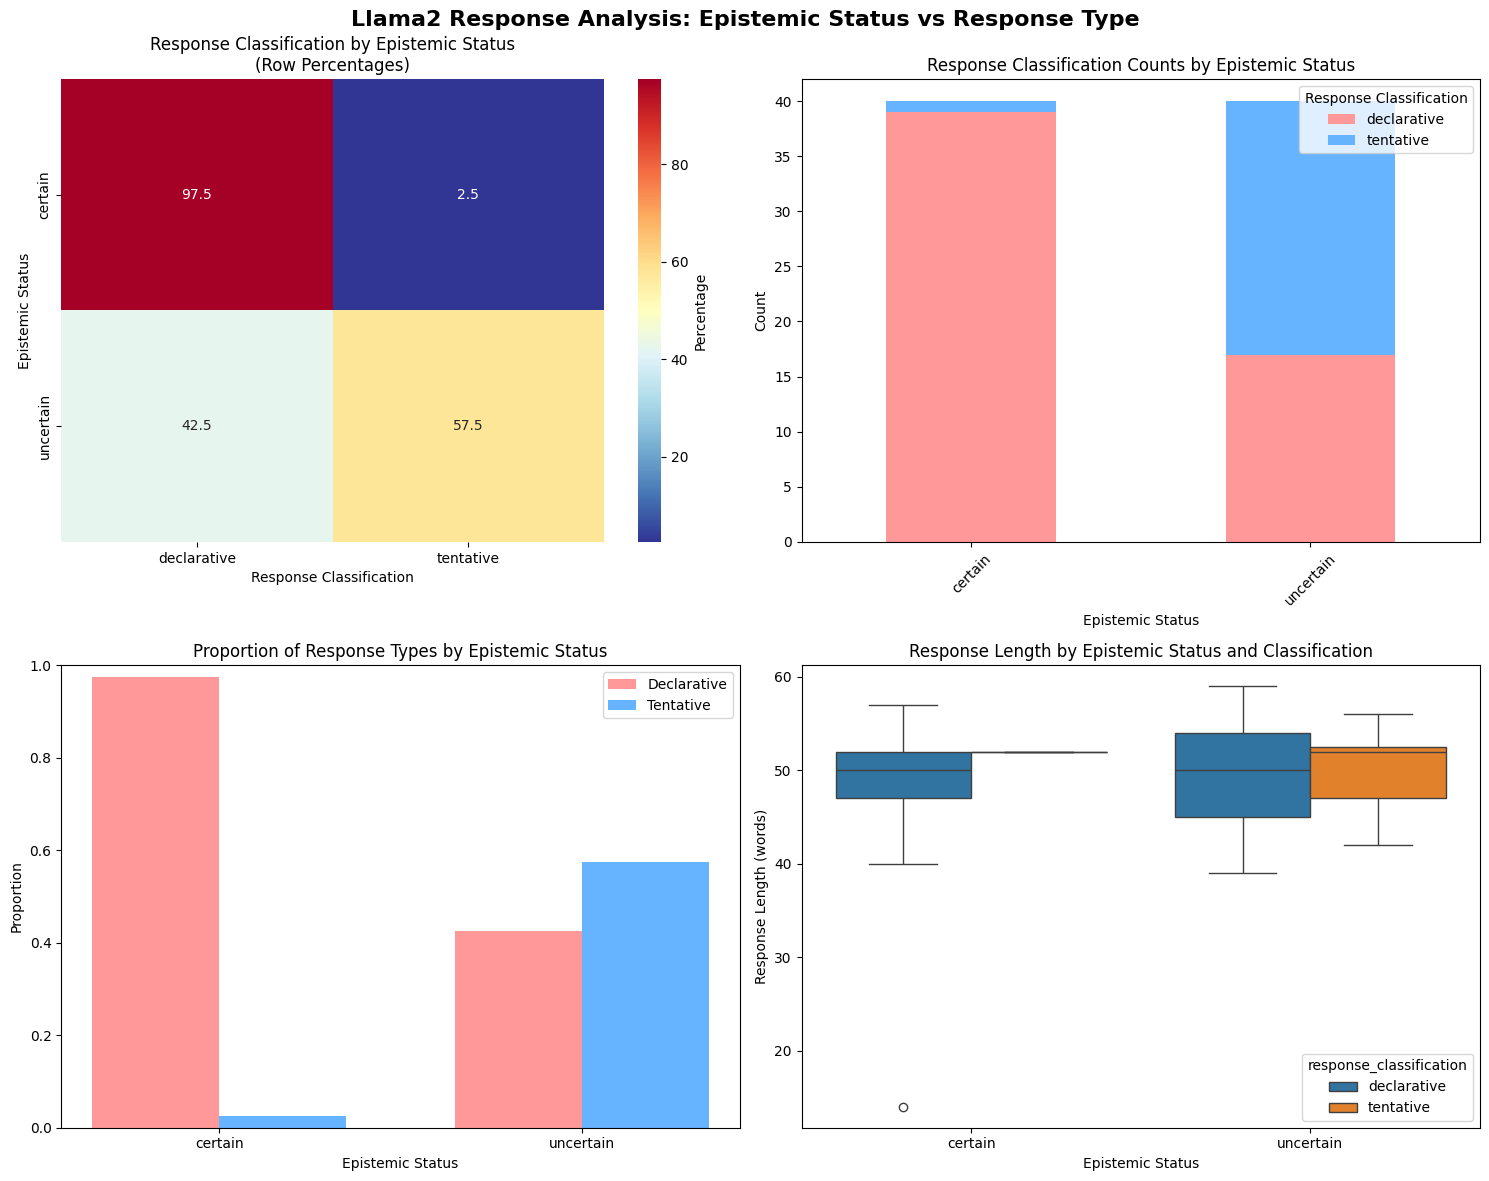


EXPERIMENT RESULTS SUMMARY
Total valid responses: 80

Epistemic Status Distribution:
  certain: 40 (50.0%)
  uncertain: 40 (50.0%)

Overall Response Classification:
  declarative: 56 (70.0%)
  tentative: 24 (30.0%)

Cross-tabulation (Response Classification by Epistemic Status):
response_classification  declarative  tentative  All
epistemic_status                                    
certain                           39          1   40
uncertain                         17         23   40
All                               56         24   80

Percentages within each Epistemic Status:
response_classification  declarative  tentative
epistemic_status                               
certain                         97.5        2.5
uncertain                       42.5       57.5

Chi-square test of independence:
Chi-square statistic: 26.2500
p-value: 0.0000
Degrees of freedom: 1
Result: Significant association between epistemic status and response classification! 🎉


In [35]:
create_visualizations(df)

### Before proceeding, save the data from the long experiment

In [38]:
df.to_csv('data/prompts_response_classification.csv')

### Summmary for step 1 - step 3 before moving to the next experiment

Before using Llama2-13b model, I used Qwen2-1.5b model for the same experiment, which ended up with a weak 62% signal. 

Now this new experiment result is truly surprising, a big shift from the old experiment with Qwen2-1.5b. A zero p value actually makes sense for a model specifically intensively trained on interacting with & assisting human. But what more interesting is the asymmetry here: when the user is certain, the model is 97.% declarative, while when the user is uncertain, the model response is 57% tentative. This implies handling uncertainty is a combination of weak, noisy, easily overriden, competing mechanisms.

How to explain this asymmetry? The plan is to run two related but opposing patching and see what will happen.

## step 4. The "certainty" circuit

In [43]:
# Clean run uses CERTAIN prompts to restore the declarative style.
clean_prompts = df[df["epistemic_status"] == "certain"]["prompt"].dropna().tolist()
# Corrupted run uses UNCERTAIN prompts.
corrupted_prompts = df[df["epistemic_status"] == "uncertain"]["prompt"].dropna().tolist()

DATASET_SIZE = 40
clean_prompts = clean_prompts[:DATASET_SIZE]
corrupted_prompts = corrupted_prompts[:DATASET_SIZE]

In [45]:
# --- Define the Metric ---
clean_token_id = model.to_single_token("is")
corrupted_token_id = model.to_single_token("might")
print(f"Metric: logit('is') - logit('might')")

Metric: logit('is') - logit('might')


In [46]:
# --- Get Baseline Logit Diffs ---
clean_tokens = model.to_tokens(clean_prompts)
corrupted_tokens = model.to_tokens(corrupted_prompts)

In [49]:
print("\nRunning baseline forward passes...")
clean_logits, clean_cache = model.run_with_cache(clean_tokens)
corrupted_logits, _ = model.run_with_cache(corrupted_tokens)


Running baseline forward passes...


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.00 MiB. GPU 0 has a total capacity of 47.53 GiB of which 256.00 KiB is free. Process 834954 has 47.52 GiB memory in use. Of the allocated memory 46.74 GiB is allocated by PyTorch, and 483.19 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)